In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Além da Regressão Linear

Assim como os métodos de classificação tem como ponto de partida a regressão logística, os **regressores** tem como ponto de partida a regressão linear.

No entanto, a regressão linear é inadequada em muitas situações. Vamos ver alguns motivos pelas quais uma regressão linear pode ser uma escolha inadequada para resolver nosso problema:

1. **Colinearidade** muitas vezes as variáveis de entrada do nosso modelo apresentam correlações entre si. Podemos extender esse conceito e *imaginar um dataset onde as variáveis de entrada são, em si, resultados de outros modelos*.
1. **Função não-linear desconhecida**: Vimos que mesmo sendo *linear* uma regressão pode representar relações mais complexas através da transformação de variáveis. No entanto, isso parte do pressuposto que conhecemos, ou que pelo menos conseguimos descobrir, qual a função que liga cada uma de nossas variáveis de entrada à variável resposta.

Hoje veremos alguns métodos para tratar essas duas questões - primeiro extendendo o modelo da regressão e depois através dos algoritmos de Machine Learning.

## Dataset

Na aula de hoje utilizaremos o dataset `Ames Housing Dataset`, obtido através do Kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Este dataset é uma extensão e atualização dos dados de uma tabela muito utilizada na construção e validação de métodos estatísticos, o Boston Housing Dataset.

O dataset completo compreende 81 variáveis, e a tarefa é, utilizando parte dessas variáveis, estimar o preço de venda de imóveis.  Os dados da tabela foram coletados entre 2006 e 2010 na cidade de Ames em Iowa-EUA a partir da venda de imóveis. Nosso objetivo será construir um modelo que a partir das caracteristicas da casa e sua localização seja capaz de prever o preço pelo qual esta foi vendida!

In [64]:
tb_housing = pd.read_csv("data/tb_ames_housing.csv")


In [65]:
tb_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Uma boa parte das variáveis presentes são variáveis categóricas. Para aula de hoje focaremos na análise das variáveis continuas, simplificando a análise do resultado dos modelos. Primeiro, vamos mapear quais colunas são numéricas e, destas, quais contém variáveis explanatórias (removendo IDs, variáveis relativas à data e variáveis categóricas codificadas como número).

In [66]:
tb_housing.select_dtypes(include=[np.number]).columns


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [67]:
len(tb_housing.select_dtypes(include=[np.number]).columns)

38

Antes de excluir as variáveis de data vamos calcular a idade do imóvel no momento da venda através do tempo entre a última reforma (ou construção do imóvel) e a data de venda.

In [68]:
tb_housing["age_when_sold"] = tb_housing["YrSold"] - tb_housing["YearRemodAdd"]


In [69]:
col_exclude = [
    "Id",
    "MSSubClass",
    "MoSold",
    "YrSold",
    "GarageYrBlt",
    "YearBuilt",
    "YearRemodAdd",
]
tb_housing_num = (
    tb_housing.select_dtypes(include=[np.number])
    .drop(col_exclude, axis=1)
    .dropna()
    .copy()
)


In [70]:
pd.set_option("display.max_columns", 500)

In [71]:
tb_housing_num.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,age_when_sold
0,65.0,8450,7,5,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,208500,5
1,80.0,9600,6,8,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,181500,31
2,68.0,11250,7,5,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,223500,6
3,60.0,9550,7,5,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,140000,36
4,84.0,14260,8,5,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,250000,8


In [72]:
tb_housing_num.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice', 'age_when_sold'],
      dtype='object')

Agora vamos separar selecionar nossas variáveis de entrada (escolhendo-as através da lista x_vars) e separar nossos dados em train e test para termos boas estimativas do erro de cada modelo construído.

In [73]:
x_vars = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "age_when_sold",
]
X_train, X_test, y_train, y_test = train_test_split(
    tb_housing_num[x_vars], tb_housing_num["SalePrice"], test_size=0.2
)
scaler = StandardScaler()
scaler.fit(X_train)


StandardScaler()

Como estaremos construindo modelos cujo protótipo é a regressão linear, vamos construir uma e medir o erro para termos um baseline de performance dos modelos seguintes.

In [74]:
scaler.transform(X_train)

array([[ 0.42625011, -0.08333657, -0.76819142, ..., -0.0643932 ,
        -0.1471196 , -0.95857162],
       [-0.28968796,  0.08884547, -0.76819142, ..., -0.0643932 ,
        -0.1471196 , -0.34673206],
       [ 0.88950416,  0.1984908 , -0.76819142, ..., -0.0643932 ,
        -0.1471196 ,  0.82988248],
       ...,
       [-0.83717002, -0.46609418, -2.15514325, ..., -0.0643932 ,
        -0.1471196 , -0.81737787],
       [ 0.13145208,  0.22675598,  0.61876041, ..., -0.0643932 ,
        -0.1471196 , -0.44086122],
       [ 0.08933808, -0.15517723,  0.61876041, ..., -0.0643932 ,
        -0.1471196 , -1.05270078]])

In [75]:
lin_fit = LinearRegression()
lin_fit.fit(scaler.transform(X_train), y_train)

LinearRegression()

In [76]:
y_pred = lin_fit.predict(scaler.transform(X_test))

In [77]:
y_pred

array([358230.37516345, 115683.33618648, 215432.54579171, 289350.79430793,
       215291.12386984,  36772.87316005, 143942.89123616, 113426.3461562 ,
       285094.99442176, 104390.54823235, 113495.98765035, 323321.01246406,
       139122.96795922,  49951.32791531, 166472.55779797, 156294.46533232,
       154856.26045085, 233492.07402961, 178587.12048998, 164262.00070467,
       414494.2532368 , 200800.87514533, 286764.44377937, 248107.86242325,
       150446.24663161, 235757.95934334,  88337.67070129, 190503.2886731 ,
       170315.44739619, 129582.27395096, 105276.10912647,  94451.90881785,
       189235.4425    , 147901.15639674, 132363.24618638, 239305.40307559,
       211267.84077991, 139398.25588406, 198459.88319504, 229729.80501418,
       226560.73530198, 255145.40373588, 125521.48502049, 208930.62338582,
       142678.35107475, 265288.34351268, 138733.84960585, 120042.32032143,
       286205.4514213 , 116885.65802269, 198520.76594636, 116321.52374976,
       160418.12218151, 1

In [78]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test, y_pred))

29352.533955112183

In [79]:
print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_pred), 2)}"
)


Erro de $29352.53 em $181179.97


In [80]:
30864/185931 # MAPE -> só existe para variáveis positivas

0.16599706342675508

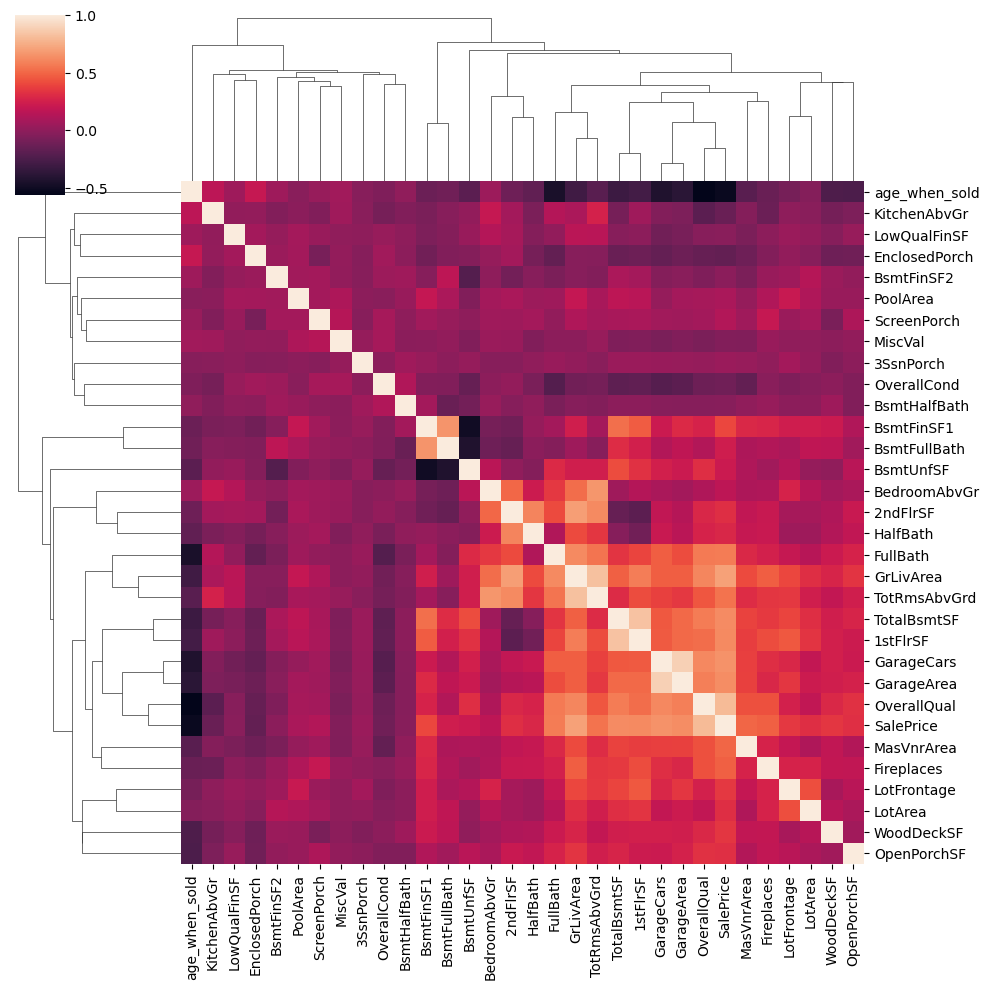

In [81]:
sns.clustermap(tb_housing_num.corr())

## Extensões da Regressão

### Regressão Lasso

A regressão de Lasso trata a questão de colinearidade penalizando os coeficientes de variáveis correlatas entre si. O lasso aumenta a esparsidade dos coeficientes, reduzindo alguns coeficientes à zero e mantendo outros intactos.

**Quando utilizar:** quando temos uma estrutura de correlação entre as variáveis de entrada complexa e queremos um modelo interpretável sem sacrificar o poder preditivo do conjunto completo de variáveis.

**Análogo** uma regressão linear onde fizemos um feature selection que ao invés de excluir variáveis reduz a importância delas no modelo.

In [82]:
from sklearn.linear_model import LassoCV


A interface de utilização da regressão de lasso dentro da SKLEARN é igual aos outros modelos: inicializamos o objeto através da classe `LassoCV`, importada do sub-módulo `sklearn.linear_model`, e utilizamos o método fit para iniciar a aprendizagem do modelo.

O único hiperparâmetro de inicialização do modelo é a quantidade de dobras na validação cruzada: como o Lasso precisa estimar um parâmetro de regularização a função utiliza internamente uma validação cruzada para escolhe este parâmetro de forma ótima.

In [83]:
las_fit = LassoCV(cv=5)
las_fit.fit(scaler.transform(X_train), y_train)


LassoCV(cv=5)

In [84]:
y_pred = las_fit.predict(scaler.transform(X_test))
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)


Erro de $33455.34 em $181540.45


In [85]:
33609/184835

0.1818324451537858

O erro da regressão de lasso é maior! Será que isso indica um modelo pior? Vamos comparar os coeficientes estimados para cada variável para entender melhor o que está acontencedo. Primeiro vamos inicializar um dataframe com os coeficienetes da regressão lasso.

In [86]:
las_fit.coef_

array([    0.        ,   624.43963961, 33008.22897905,     0.        ,
        4201.43196089,  3356.53673603,     0.        ,    -0.        ,
        5694.46856185,  2376.09738516,     0.        ,    -0.        ,
       18293.05766401,  1353.99122585,    -0.        ,   452.49673326,
           0.        ,    -0.        ,    -0.        ,     0.        ,
        2547.2596161 ,  9470.10091633,     0.        ,   451.30978639,
           0.        ,    -0.        ,     0.        ,     0.        ,
          -0.        ,     0.        , -4657.29875703])

In [87]:
coef_lin = pd.DataFrame(
    np.round(las_fit.coef_, 2), 
    index=X_train.columns, 
    columns=["lasso_fit"]
)


In [88]:
coef_lin

,lasso_fit
LotFrontage,0.00
LotArea,624.44
OverallQual,33008.23
OverallCond,0.00
MasVnrArea,4201.43
BsmtFinSF1,3356.54
BsmtFinSF2,0.00
BsmtUnfSF,-0.00
TotalBsmtSF,5694.47
1stFlrSF,2376.10


Agora vamos acrescentar os coeficientes da regressão linear.

In [89]:
coef_lin["lin_fit"] = np.round(lin_fit.coef_, 2)


O que podemos inferir da tabela abaixo?

In [90]:
coef_lin


,lasso_fit,lin_fit
LotFrontage,0.00,7.718800e+02
LotArea,624.44,3.825240e+03
OverallQual,33008.23,2.678272e+04
OverallCond,0.00,2.454190e+03
MasVnrArea,4201.43,6.875610e+03
BsmtFinSF1,3356.54,-7.665276e+15
BsmtFinSF2,0.00,-2.437053e+15
BsmtUnfSF,-0.00,-7.285364e+15
TotalBsmtSF,5694.47,7.447737e+15
1stFlrSF,2376.10,1.507367e+16


Vamos analisar os 5 coeficientes que apresentaram a maior diferença relativa entre as duas regressões.

In [91]:
coef_lin["diff_lin_lasso"] = abs(coef_lin["lin_fit"] - coef_lin["lasso_fit"]) / abs(
    coef_lin["lin_fit"]
)
coef_lin = coef_lin.sort_values("diff_lin_lasso", ascending=False)
coef_lin.head()


,lasso_fit,lin_fit,diff_lin_lasso
GrLivArea,18293.06,-2.057441e+16,1.0
BsmtFinSF1,3356.54,-7.665276e+15,1.0
LotFrontage,0.00,7.718800e+02,1.0
EnclosedPorch,-0.00,-5.800300e+02,1.0
TotRmsAbvGrd,0.00,9.065490e+03,1.0


O caminho do lasso (`lasso path`) é a forma como o método foi 'encolhendo' cada coeficiente. A função `LassoCV` utiliza-se de validação cruzada para escolher um ponto neste caminho que minimize o erro de projeção. Podemos visualizar o caminho do lasso através do método `path`. Primeiro vamos inicializar um DataFrame com os dados do caminho de cada variável.

In [92]:
las_fit.path(scaler.transform(X_train), y_train)[0]

array([6.81215666e+04, 6.35304010e+04, 5.92486646e+04, 5.52555029e+04,
       5.15314669e+04, 4.80584185e+04, 4.48194420e+04, 4.17987616e+04,
       3.89816649e+04, 3.63544312e+04, 3.39042642e+04, 3.16192303e+04,
       2.94882000e+04, 2.75007940e+04, 2.56473325e+04, 2.39187881e+04,
       2.23067419e+04, 2.08033421e+04, 1.94012665e+04, 1.80936861e+04,
       1.68742322e+04, 1.57369654e+04, 1.46763466e+04, 1.36872100e+04,
       1.27647378e+04, 1.19044372e+04, 1.11021180e+04, 1.03538724e+04,
       9.65605605e+03, 9.00527019e+03, 8.39834512e+03, 7.83232477e+03,
       7.30445229e+03, 6.81215666e+03, 6.35304010e+03, 5.92486646e+03,
       5.52555029e+03, 5.15314669e+03, 4.80584185e+03, 4.48194420e+03,
       4.17987616e+03, 3.89816649e+03, 3.63544312e+03, 3.39042642e+03,
       3.16192303e+03, 2.94882000e+03, 2.75007940e+03, 2.56473325e+03,
       2.39187881e+03, 2.23067419e+03, 2.08033421e+03, 1.94012665e+03,
       1.80936861e+03, 1.68742322e+03, 1.57369654e+03, 1.46763466e+03,
      

In [93]:
lasso_path = pd.DataFrame(
    las_fit.path(scaler.transform(X_train), y_train)[1].T, columns=X_train.columns
)
lasso_path["alpha"] = las_fit.path(scaler.transform(X_train), y_train)[0]
lasso_path.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,age_when_sold,alpha
0,0.0,0.0,0.000000,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,68121.566553
1,0.0,0.0,4591.165591,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,63530.400962
2,0.0,0.0,8872.901987,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,59248.664566
3,0.0,0.0,12866.063680,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,55255.502873
4,0.0,0.0,16590.099640,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,51531.466913


Agora vamos utilizar o método `melt` para transformar este DataFrame em formato longo.

In [94]:
lasso_path_long = lasso_path.melt(id_vars=["alpha"])
lasso_path_long.head(10)


,alpha,variable,value
0,68121.566553,LotFrontage,0.0
1,63530.400962,LotFrontage,0.0
2,59248.664566,LotFrontage,0.0
3,55255.502873,LotFrontage,0.0
4,51531.466913,LotFrontage,0.0
5,48058.418513,LotFrontage,0.0
6,44819.441951,LotFrontage,0.0
7,41798.761569,LotFrontage,0.0
8,38981.664935,LotFrontage,0.0
9,36354.431185,LotFrontage,0.0


In [95]:
lasso_path_long[lasso_path_long["variable"] == "OverallQual"]


,alpha,variable,value
200,68121.566553,OverallQual,0.000000
201,63530.400962,OverallQual,4591.165591
202,59248.664566,OverallQual,8872.901987
203,55255.502873,OverallQual,12866.063680
204,51531.466913,OverallQual,16590.099640
...,...,...,...
295,90.052702,OverallQual,26897.426829
296,83.983451,OverallQual,26888.801001
297,78.323248,OverallQual,26880.759003
298,73.044523,OverallQual,26875.418333


In [96]:
lasso_path_long["abs_value"] = abs(lasso_path_long["value"])


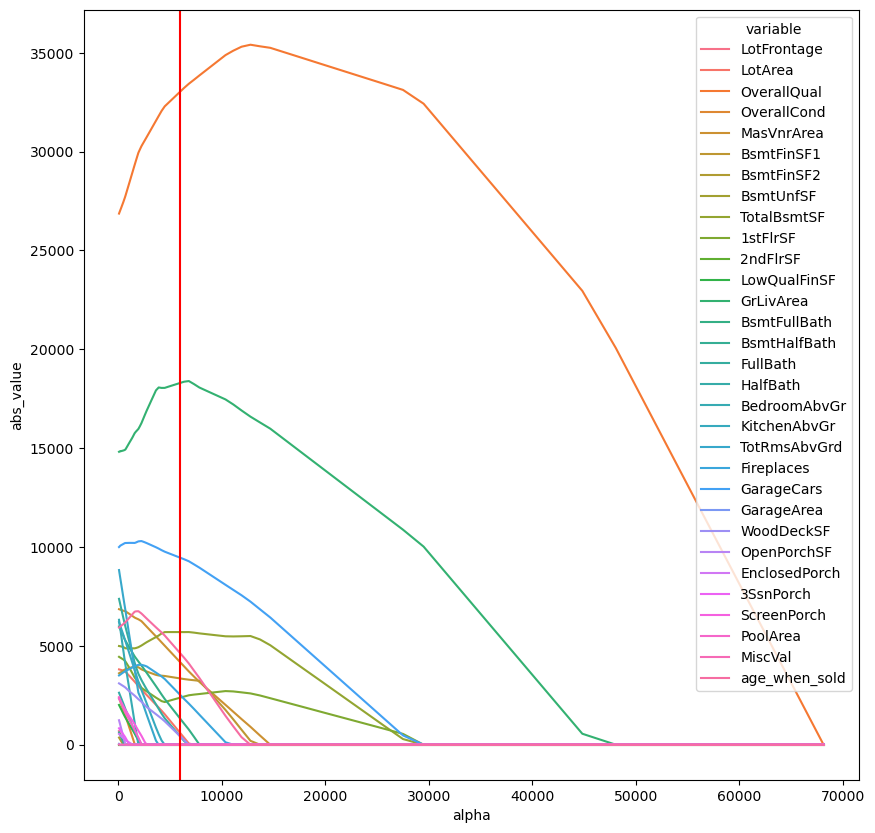

In [97]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=lasso_path_long, x="alpha", y="abs_value", hue="variable")
plt.axvline(las_fit.alpha_, color="red")


**Para se aprofundar**: Regressão LARS e Lasso-LARS

https://hastie.su.domains/ElemStatLearn/

### Regressão Ridge

Assim como a regressão de lasso, a regressão ridge busca resolver os problemas de colinearidade entre coeficientes e variáveis irrelevantes. No entanto, enquanto o lasso encolhe o coeficiente de algumas variáveis, a regressão ridge encolhe gradualmente todos os coeficientes. Ela é um método ideal para lidar com grandes conjuntos de variáveis, resolvendo automaticamente os problemas de colinearidade e overfitting que podem aconcetecer conforme aumentamos a complexidade de um modelo.

Uma utilização comum é na estimativa de funções não lineares a partir da adição de tranformações polinomiais das variáveis de entrada. Vamos continuar a análise do dataset de housing adicionando uma transformação não-linear bem útil: o beta-spline.

**Quando utilizar:** um método extremamente flexível, capaz de tratar grandes conjuntos de variáveis de forma simples. Sempre que quisermos utilizar transformações complexa para estimar formas funcionais desconhecidas. Muitas vezes apresenta performance superior à métodos bem ma
is complexos como boosting ou redes neurais.

**Problemas:** difícil interpretação do modelo, não captura relações entre variáveis como modelos de Boosting ou redes neurais.

**Análogo:** feature selection onde reduzimos a importancia do conjunto da variáveis para compensar o número de coeficientes sendo estimado.

In [98]:
from sklearn.linear_model import RidgeCV


Olhando apenas a descrição, a regressão de ridge parece identica ao Lasso. Essa impressão não esta completamente incorreta: ambas fazem parte da mesma classe de métodos: **métodos de regularização**. Para entender melhor a diferença de cada uma, vamos começar vendo uma transformação muito útil na construção de modelo preditivos lineares: os splines.

In [99]:
X_ex = pd.DataFrame({"x": np.linspace(0, 10, 100)})
X_ex


,x
0,0.00000
1,0.10101
2,0.20202
3,0.30303
4,0.40404
...,...
95,9.59596
96,9.69697
97,9.79798
98,9.89899


A transformação de spline é uma forma de representar relações não-lineares através de um modelo linear (como a transformação logaritmica). Podemos utilizar essa transformação através do objeto `SplineTransformer`, do sub-módulo `sklearn.preprocessing`.

In [100]:
from sklearn.preprocessing import SplineTransformer


Inicializamos o objeto como os outros transformadores da sklearn. O objeto tem diversos parâmetros que nos permitem controlar quantos splines iremos gerar e qual a complexidade deles. 

In [101]:
spl_trans = SplineTransformer()
spl_trans.fit(X_ex)

SplineTransformer()

In [102]:
spl_trans.transform(X_ex).shape

(100, 7)

Vamos utilizar o método `transform` para construir um DataFrame com os resultados da transformação.

In [103]:
X_ex_spl = pd.DataFrame(
    spl_trans.transform(X_ex),
    columns=["S" + str(i) for i in range(spl_trans.n_features_out_)],
)
X_ex_spl["x"] = X_ex["x"]


In [104]:
X_ex_spl

,S0,S1,S2,S3,S4,S5,S6,x
0,0.166667,0.666667,0.166667,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.147270,0.665067,0.187652,0.000011,0.000000,0.000000,0.000000,0.10101
2,0.129440,0.660401,0.210072,0.000088,0.000000,0.000000,0.000000,0.20202
3,0.113110,0.652865,0.233728,0.000297,0.000000,0.000000,0.000000,0.30303
4,0.098215,0.642658,0.258424,0.000704,0.000000,0.000000,0.000000,0.40404
...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000704,0.258424,0.642658,0.098215,9.59596
96,0.000000,0.000000,0.000000,0.000297,0.233728,0.652865,0.113110,9.69697
97,0.000000,0.000000,0.000000,0.000088,0.210072,0.660401,0.129440,9.79798
98,0.000000,0.000000,0.000000,0.000011,0.187652,0.665067,0.147270,9.89899


Agora vamos visualizar a transformação comparando cada spline gerada com o valor original.

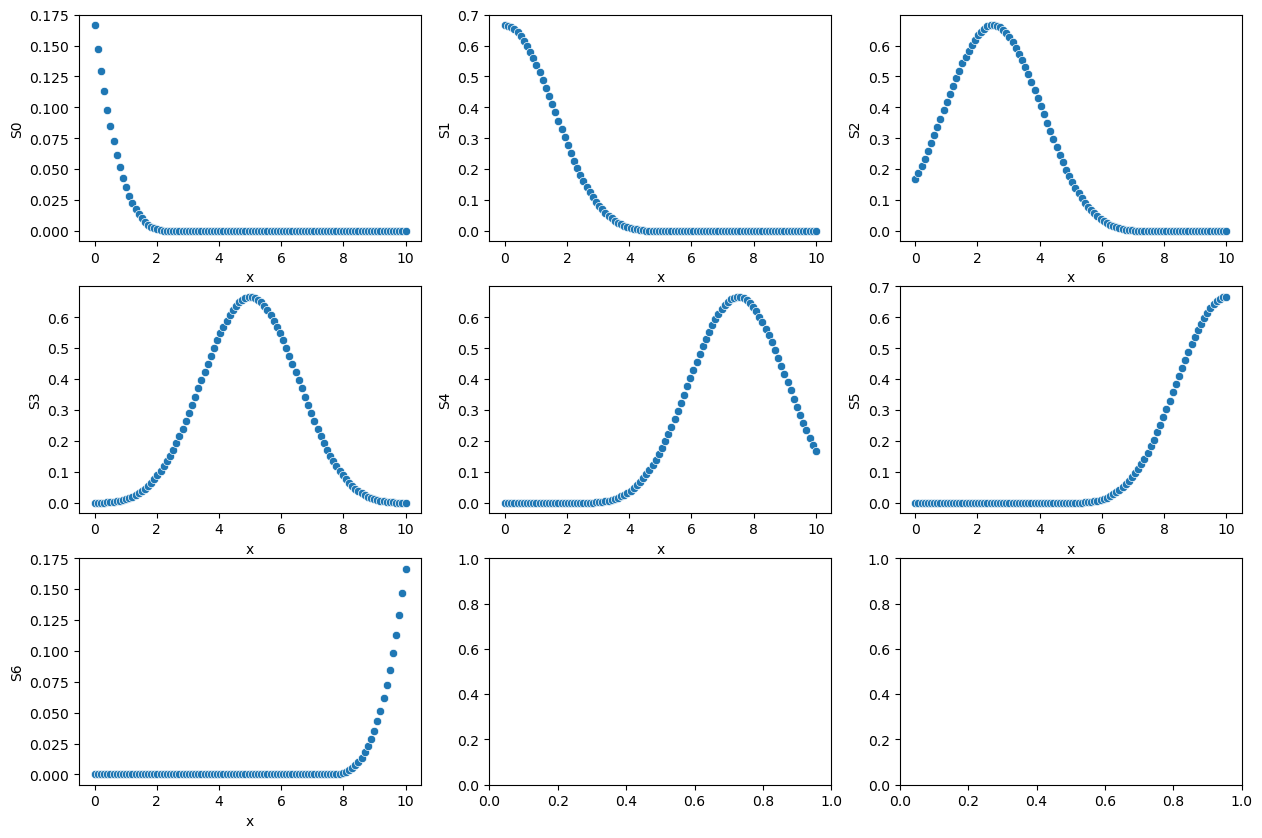

In [105]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
sp = 0
for i in range(3):
    for j in range(3):
        try:
            sns.scatterplot(data=X_ex_spl, x="x", y="S" + str(sp), ax=ax[i][j])
        except ValueError:
            continue
        sp += 1


Os splines funcionam como **um tipo de variável dummy continua**: ao invés de serem simplesmente binários, representam de maneira continua os pontos onde nossa variável X assume certos valores. Por exemplo, quando X = 10, os 4 primeiros splines (de 0 à 3) tem valor 0. Os 3 seguintes tem valores crescentes. **Quando inserimos isso em uma regressão estimamos efeitos locais**: o os splines 4, 5 e 6 conterão os efeitos da variável X sobre nossa variável resposta apenas quando X tem um valor alto!

Os métodos de ridge regression existem para tratar desse tipo de transformação: quando utilizamos um spline, como no exemplo acima, multiplicamos o número de variáveis que estamos inserindo em nosso modelo. Para controlar essa explosão de complexidade o ridge regression penaliza os coeficientes de forma conjunta, ao contrário do lasso, que penaliza cada coeficiente individualmente. Vamos ver isso na prática. Primeiro iremos treinar nossos splines.

In [106]:
spl_house = SplineTransformer(degree=2)
spl_house.fit(scaler.transform(X_train))


SplineTransformer(degree=2)

Agora vamos utilizar o método `RidgeCV`, do sub-módulo `sklearn.linear_models`. Assim como no Lasso, o único parâmetro que devemos especificar é o `cv`. Utilizaremos nossas splines como features de entrada, passando o DataFrame `X_train` através do `scaler` e do `spl_house` antes de alimenta-lo ao `fit`.

In [107]:
scaler.transform(X_train).shape

(956, 31)

In [108]:
spl_house.transform(scaler.transform(X_train)).shape

(956, 186)

In [109]:
rid_fit = RidgeCV(cv=5)
rid_fit.fit(spl_house.transform(scaler.transform(X_train)), y_train)


RidgeCV(cv=5)

In [110]:
y_pred = rid_fit.predict(spl_house.transform(scaler.transform(X_test)))
np.sqrt(mean_squared_error(y_test, y_pred))

24369.817597244255

In [111]:
28350/185000

0.15324324324324323

In [113]:
from sklearn.metrics import mean_squared_error

for i in range(2, 25):
    spl_house = SplineTransformer(n_knots=i)
    spl_house.fit(scaler.transform(X_train))
    rid_fit = RidgeCV(cv=5)
    rid_fit.fit(spl_house.transform(scaler.transform(X_train)), y_train)
    y_pred = rid_fit.predict(spl_house.transform(scaler.transform(X_test)))
    print(
        f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
    )


Erro de $32638.18 em $181540.45
Erro de $25787.47 em $181540.45
Erro de $24834.56 em $181540.45
Erro de $24942.5 em $181540.45
Erro de $25014.1 em $181540.45
Erro de $24835.85 em $181540.45
Erro de $25345.29 em $181540.45
Erro de $25573.51 em $181540.45
Erro de $25947.82 em $181540.45
Erro de $25971.61 em $181540.45
Erro de $26099.54 em $181540.45
Erro de $26040.25 em $181540.45
Erro de $26231.06 em $181540.45
Erro de $26363.25 em $181540.45
Erro de $26367.15 em $181540.45
Erro de $26521.1 em $181540.45
Erro de $26373.66 em $181540.45
Erro de $26570.97 em $181540.45
Erro de $26406.43 em $181540.45
Erro de $26524.03 em $181540.45
Erro de $26549.87 em $181540.45
Erro de $26533.1 em $181540.45
Erro de $26555.41 em $181540.45


Como podemos ver, mesmo adicionando inúmeros features não sofremos com overfitting. Essa é a principal qualidade do ridge regression, a capacidade de lidar com features criados através de transformações não lineares sem (muito) risco de overfitting.

Vamos comparar isto com uma regressão linear que utiliza os mesmos splines como features de entrada.

In [51]:
lin_spline_fit = LinearRegression()
lin_spline_fit.fit(spl_house.transform(scaler.transform(X_train)), y_train)
y_pred = lin_spline_fit.predict(spl_house.transform(scaler.transform(X_test)))
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $1052958752542763.4 em $179215.02


**Para se aprofundar** A regressão ElasticNet, que combina o Lasso com o Ridge.

## Métodos Não-Lineares
Embora os métodos lineares tenham vantagens claras (simplicidade, velocidade de implantação e interpretabilidade), em diversos problemas conseguimos uma performance preditiva melhor utilizando métodos não-lineares. Enquanto métodos lineares **sempre partem de uma função conhecida**, a da regressão linear, métodos não-lineares **não tem uma função conhecida prévia**: estimar esta função é *parte do trabalho do algoritmo*. Todos os classificadores que vimos dentro da SKLEARN até agora tem um regressor equivalente (árvores de decisão, kNN e métodos de ensemble) que podemos instanciar trocando o sufixo `Classifier` por `Regressor` (por exemplo, de `DecisionTreeClassifier` para `DecisionTreeRegressor`).

Sendo assim vamos comparar a performance do regressor de Floresta Aleatória, `RandomForestRegressor` (equivalente ao `RandomForestClassifier`) da sklearn com as regressões que fizemos até agora e aprender um método de outra biblioteca que representa o estado da arte em métodos de Machine Learning.

### Regressor de Floresta Aleatória

In [52]:
from sklearn.ensemble import RandomForestRegressor


In [53]:
from sklearn.pipeline import Pipeline

Vamos consolidar o nosso modelo (incluindo as etapas de pré-processamento) em um pipeline:

In [54]:
x_vars = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "age_when_sold",
]

In [55]:
X = tb_housing_num[x_vars]
y = tb_housing_num["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

sca = StandardScaler()
ptrans = PowerTransformer()
spline = SplineTransformer()
rfr_fit = RandomForestRegressor()

pipeline = Pipeline(
    [("sca", sca), ("ptrans", ptrans), ("spline", spline), ("rfr_fit", rfr_fit)]
)


In [56]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('sca', StandardScaler()), ('ptrans', PowerTransformer()),
                ('spline', SplineTransformer()),
                ('rfr_fit', RandomForestRegressor())])

In [57]:
y_pred = pipeline.predict(X_test)
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $33892.12 em $183793.06


In [58]:
coef_lin[np.abs(coef_lin["lasso_fit"]) > 0.01].index

Index(['GarageArea', '1stFlrSF', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea',
       'BsmtFullBath', 'WoodDeckSF', 'LotArea', 'MasVnrArea', 'Fireplaces',
       'OverallQual', 'age_when_sold', 'GarageCars'],
      dtype='object')

In [59]:
X = tb_housing_num[coef_lin[np.abs(coef_lin["lasso_fit"]) > 0.01].index]
y = tb_housing_num["SalePrice"]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

sca = StandardScaler()
ptrans = PowerTransformer()
spline = SplineTransformer()
rfr_fit = RandomForestRegressor(n_estimators = 1000)

pipeline = Pipeline(
    [("sca", sca), ("ptrans", ptrans), ("spline", spline), ("rfr_fit", rfr_fit)]
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('sca', StandardScaler()), ('ptrans', PowerTransformer()),
                ('spline', SplineTransformer()),
                ('rfr_fit', RandomForestRegressor(n_estimators=1000))])

In [61]:
y_pred = pipeline.predict(X_test)
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $34240.62 em $183793.06


Um primeiro resultado razoável. No entanto, como estamos usando um modelo com diversos hiperparâmetros, precisamos realizar uma busca através desse espaço de hiperparâmetros para encontrar o melhor modelo possível. Antes de nos preocuparmos com **como** faremos essa busca, vamos definir **o que** vamos buscar:

1. **RandomForestRegressor** `n_estimators` de `rfr_fit`: número de árvores na floresta. Quanto maior, mais complexo o modelo.
1. **RandomForestRegressor** `max_depth` de `rfr_fit`: profundidade máxima de cada árvore. Quanto maior, mais complexo o modelo.
1. **SplineTransformer** `degree` de `spline`: número de nós de splines. Quanto maior, mais complexo o modelo.

Inicialmente, vamos representar esse espaço de busca como três listas.

In [118]:
max_depth = [1, 2, 4, 8]
n_estimators = [100, 200, 400, 800]
n_knots = [2, 3, 4, 5]

In [117]:
for m in max_depth:
    for e in n_estimators:
        for k in n_knots:
            print(m, e, k)

1 100 2
1 100 3
1 100 4
1 200 2
1 200 3
1 200 4
1 400 2
1 400 3
1 400 4
1 800 2
1 800 3
1 800 4
2 100 2
2 100 3
2 100 4
2 200 2
2 200 3
2 200 4
2 400 2
2 400 3
2 400 4
2 800 2
2 800 3
2 800 4
4 100 2
4 100 3
4 100 4
4 200 2
4 200 3
4 200 4
4 400 2
4 400 3
4 400 4
4 800 2
4 800 3
4 800 4
8 100 2
8 100 3
8 100 4
8 200 2
8 200 3
8 200 4
8 400 2
8 400 3
8 400 4
8 800 2
8 800 3
8 800 4


Agora, vamos pensar como podemos fazer essa busca. A forma mais simples é através de um loop for, onde iteramos sobre cada combinação de hiperparâmetros e calculamos o erro de cada modelo. Ao invés de construírmos os loops manualmente, vamos utilizar o `GridSearchCV` para fazer esta busca:

In [115]:
from sklearn.model_selection import GridSearchCV

In [119]:
sca = StandardScaler()
ptrans = PowerTransformer()
spline = SplineTransformer()
rfr_fit = RandomForestRegressor()
pipeline = Pipeline(
    [("sca", sca), ("ptrans", ptrans), ("spline", spline), ("rfr_fit", rfr_fit)]
)



In [120]:
param_grid = {
    "rfr_fit__max_depth": [1, 2, 4, 8], # <NOME_ETAPA>__<NOME_HIPERPARAMETRO>,<NOME_ETAPA>__<NOME_ETAPA>__<NOME_HP>
    "rfr_fit__n_estimators": [100, 200, 400, 800],
    "spline__n_knots": [2, 3, 4, 5],
}


clf_fit = GridSearchCV(pipeline, param_grid, n_jobs=-1)
clf_fit.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('sca', StandardScaler()),
                                       ('ptrans', PowerTransformer()),
                                       ('spline', SplineTransformer()),
                                       ('rfr_fit', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rfr_fit__max_depth': [1, 2, 4, 8],
                         'rfr_fit__n_estimators': [100, 200, 400, 800],
                         'spline__n_knots': [2, 3, 4, 5]})

In [121]:
clf_fit.best_estimator_

Pipeline(steps=[('sca', StandardScaler()), ('ptrans', PowerTransformer()),
                ('spline', SplineTransformer(n_knots=4)),
                ('rfr_fit',
                 RandomForestRegressor(max_depth=8, n_estimators=400))])

In [122]:
y_pred = clf_fit.predict(X_test)
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $30493.55 em $181540.45


In [123]:
clf_fit.best_params_

{'rfr_fit__max_depth': 8, 'rfr_fit__n_estimators': 400, 'spline__n_knots': 4}

A busca extensiva tem uma grande desvantagem: mesmo parelelizada, ela é muito lenta. Isso restringe muito o espaço de hiperparâmetros que podemos buscar em um tempo razoável. No entanto, o espaço de busca tem estrutura: **a complexidade do modelo**. Faz sentido pensarmos que existe um ponto ótimo de complexidade, onde o modelo é simples o suficiente para não sofrer de overfitting e complexo o suficiente para capturar a estrutura dos dados. 

Uma busca extensiva não tem esta informação - ela busca todas as combinações possíveis! Uma busca mais inteligente, que utilize a estrutura do espaço de busca, pode ser muito mais eficiente. Vamos ver como podemos fazer isso utilizando o `BayesSearchCV`, da biblioteca `scitkit-optimize`. Você pode instalar essa biblioteca utilizando o conda:

> conda install -c conda-forge scikit-optimize

ou o pip:

> pip install scikit-optimize

In [124]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Voltamos 20h15

In [125]:
param_grid = {
    "rfr_fit__max_depth": Integer(1, 32),
    "rfr_fit__n_estimators": Integer(1, 1000, "log-uniform"),
    "spline__n_knots": Integer(2, 12),
}

sca = StandardScaler()
ptrans = PowerTransformer()
spline = SplineTransformer()
rfr_fit = RandomForestRegressor()
pipeline = Pipeline(
    [("sca", sca), ("ptrans", ptrans), ("spline", spline), ("rfr_fit", rfr_fit)]
)

clf_fit = BayesSearchCV(pipeline, param_grid, n_jobs=-1)
clf_fit.fit(X_train, y_train)


BayesSearchCV(estimator=Pipeline(steps=[('sca', StandardScaler()),
                                        ('ptrans', PowerTransformer()),
                                        ('spline', SplineTransformer()),
                                        ('rfr_fit', RandomForestRegressor())]),
              n_jobs=-1,
              search_spaces={'rfr_fit__max_depth': Integer(low=1, high=32, prior='uniform', transform='normalize'),
                             'rfr_fit__n_estimators': Integer(low=1, high=1000, prior='log-uniform', transform='normalize'),
                             'spline__n_knots': Integer(low=2, high=12, prior='uniform', transform='normalize')})

In [132]:
clf_fit.best_estimator_

Pipeline(steps=[('sca', StandardScaler()), ('ptrans', PowerTransformer()),
                ('spline', SplineTransformer(n_knots=2)),
                ('rfr_fit',
                 RandomForestRegressor(max_depth=10, n_estimators=11))])

In [133]:
y_pred = clf_fit.predict(X_test)
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $29049.99 em $181540.45


Melhoramos o resultado da floresta anterior, mas não atingimos o resultado da regressão ridge (com splines). Vamos analisar o espaço de hiperparâmetros que o BayesSearchCV explorou através da função `plot_objective()`, do submódulo `skopt.plots`

In [134]:
from skopt.plots import plot_objective

array([[<Axes: xlabel='rfr_fit__max_depth', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='rfr_fit__n_estimators'>,
        <Axes: xlabel='rfr_fit__n_estimators', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='rfr_fit__max_depth', ylabel='spline__n_knots'>,
        <Axes: xlabel='rfr_fit__n_estimators'>,
        <Axes: xlabel='spline__n_knots', ylabel='Partial dependence'>]],
      dtype=object)

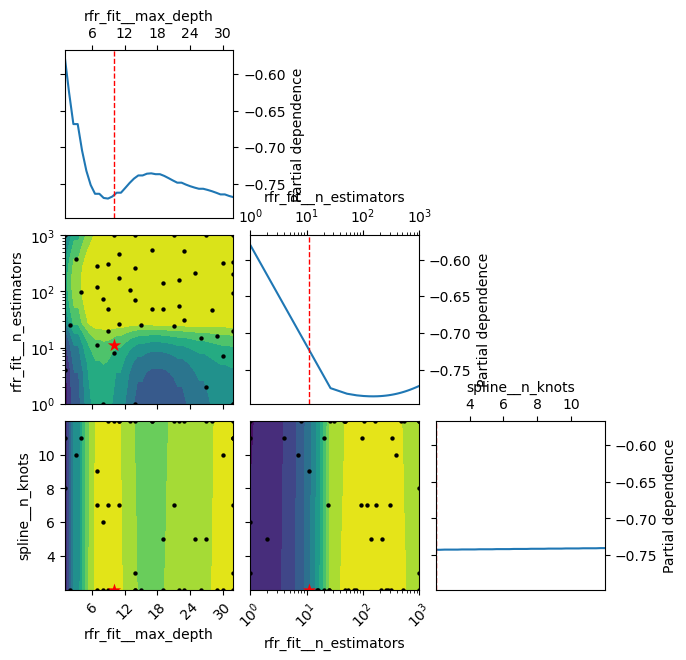

In [135]:
plot_objective(
    clf_fit.optimizer_results_[0]
)


Como podemos interpretar o gráfico acima?

### catboost

In [ ]:
import catboost as cat

In [ ]:
param_grid = {
    "spline__n_knots": Integer(2, 12),
    "cat_fit__iterations": Integer(100, 2000, "log-uniform"),
}

sca = StandardScaler()
ptrans = PowerTransformer()
spline = SplineTransformer()
cat_fit = cat.CatBoostRegressor(verbose=False)
pipeline = Pipeline(
    [("sca", sca), ("ptrans", ptrans), ("spline", spline), ("cat_fit", cat_fit)]
)

clf_fit = BayesSearchCV(pipeline, param_grid, n_jobs=-1)
clf_fit.fit(X_train, y_train)

In [ ]:
y_pred = clf_fit.predict(X_test)
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

In [ ]:
plot_objective(
    clf_fit.optimizer_results_[0]
)
